"Blockbusting" in the 21st Century?: Minority Move-ins and Neighborhood Home Value Appreciation
===

# Part One

## Introduction


Housing discrimination has, in one way or another, existed in the United
States since independence. After reconstruction, several tactics became
commonplace, including racial deed covenants, and redlining. Across the
nation, there was evidence of "white flight", or the movement of
whites out of neighborhoods with minorities due to fears over home value
depreciation or other factors. Real-estate agents commonly attempted to
abuse these fears with a tactic known as "blockbusting" in which they
would spread fear over minority-move-ins leading to a fire sale of homes
in a neighborhood (Rothstein, 2017).

Much has been researched about the modern-day effects of these past
tactics, whether in deed covenants leading to improved relative
neighborhood quality (Sood, Ehrman-Solberg, 2024), or redlining leading
to localized areas of higher poverty (Appel, Nickerson, 2016), or simply
lower quality of opportunity in majority-black neighborhoods (Chetty, et
al, 2014). There is also evidence of modern-day tactics still occurring
in the housing market, whether in lending markets (Quillian, Lee,
Honoré, 2020), or in real estates continuing to practice ``racial
steering'', the process of, whether knowing it or not, primarily showing
people of minority groups neighborhoods that are also primarily of that
minority group (Glenn, 2018). 

This paper seeks to contribute literature surrounding economic effects of racism 
by analyzing the modern accuracy of the perceived link that 50's era blockbusting relied
on -- do minority move-ins suppress home-value appreciation?

There is a long theoretical literature on discrimination, intiially starting with a model for taste-based discrimination by Gary Becker in 1957. There now many other models for discrimination, including most famously Ken Arrow's 1973 'statistical discriminination', but Becker's remains the most commonly used. There are also many theoretical frameworks for home sale matching, (Badarinza, Balasubramaniam, Ramadorai, 2024), and discriminiation in labor market matching (Combes et al, 2016), but there have been few attempts to discrimination theory in the housing market. The sole notable attempt was in (Combs, et al, 2015), which built a theoretical framework for racism in home sales and lease arrangements, and then empirically tested the lease framework. This has been extended to look at a case in Moscow, where much of the racial discirmination is overt (Avetian, 2022)

This paper contributes to this literature by applying this theoretical framework to home sales, and, in particular, analyzing the long-term effects on home values. I use loan data from Fannie Mae (FNMA) \& Freddie Mac (FHLMC) to provide data on
neighborhood move-ins, American Community Survey data to normalize, and
Zillow ZHVI data to show the change in home prices. My study has the
following methodology:

First, I select zip codes with move-ins during the 2009-2010 period
(Initial Period) that are majority white (we are uninterested in the
effect on majority-minority neighborhoods), and in metropolitan
statistical areas (necessary for appreciation normalization). I take the
minority move-in share", or the ratio of loans for new purchases made
in that zip code to minorities, and then look at those same zip codes
over the 2012-2013 period (Treatment Period) and analyze what
``treatment'' was applied (the difference in minority move-in share from
the previous period), which is our main explanatory variable. Next, we
analyze the association between the change in minority move-in-share and
the future appreciation in home prices, relative to their MSA average,
for the next 6 years (ending in 2019). This should inform us what the
effect of a sudden increase in minority move-ins is on home value
appreciation.

I find that the effect of an increase in minority move-in share on
home-value appreciation is unclear, relative to the metropolitan
statistical area. While the mean home value appreciation does decrease
in the treatment group relative to the control, there is an incredibly
high degree of variation in the data.

For regressions, I find that predictive quality is not meaningfully improved when controlling for previous neighborhood demographics, neighborhood income, or neighborhood political affiliation, and that there is not sufficient information to conclude there is a correlation between change in minority move-ins and home-value appreciation.

## Data Loading

### Loading Loan Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
def read_columns_from_txt(filename):
    data = {}
    with open(filename, "r") as f:
        for line in f:
            key, value = line.split("=", 1)
            data[key.strip()] = eval(value.strip())
    return data

columns_data = read_columns_from_txt("data/columns.txt")
cols = columns_data["cols"]
cols_pre2018 = columns_data["cols_pre2018"]
dropcols = columns_data["dropcols"]
dropcols_pre2018 = columns_data["dropcols_pre2018"]
cols_2013 = columns_data["cols_2013"]
cols_2009 = columns_data["cols_2009"]
dropcols_2009 = columns_data["dropcols_2009"]

In [9]:
def load_loans(years):
    loans_list = []
    for year in years:
        if year >= 2018: # The data format changes in 2018
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols).drop(columns=dropcols) for file in files],
                ignore_index=True
            )
        elif year in range(2010, 2018):
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols_2013).drop(columns=dropcols_pre2018)  for file in files],
                ignore_index=True
            )
        elif year in range(2009, 2010):
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols_2009).drop(columns=dropcols_2009)  for file in files],
                ignore_index=True
            )
        loans_year["year"] = year
        loans_list.append(loans_year)
        print(f"Processed {year}", end=" ")
    return pd.concat(loans_list, ignore_index=True)

In [5]:
loans = load_loans([2009, 2010, 2012, 2013]) # Please forgive the print statement! The full data can take upwards of 20 mins to load.

Processed 2009 Processed 2010 Processed 2012 Processed 2013 

I picked 2009 and 2010 as my initial years because they were some of the earliest I had. I picked 2012 and 2013 to give a year of distance but to maintain a large buffer before COVID affected home values.

### Cleaning Loan Data

In [6]:
loans = loans[loans['purpose'] == 1] # Filter to loans for new purchases

In [7]:
# Define race and ethnicity sets
races_set = {3} # Black
ethnicities_set = {1} # Hispanic

# Extract borrower and coborrower race
borrower_races = loans[[col for col in loans.columns if col.startswith("borrower_race")]]
coborrower_races = loans[[col for col in loans.columns if col.startswith("coborrower_race")]]
borrower_ethnicities = loans[[col for col in loans.columns if col.startswith("borrower_ethnicity")]]
coborrower_ethnicities = loans[[col for col in loans.columns if col.startswith("coborrower_ethnicity")]]

# Check if any race or ethnicity belongs to minority groups
borrower_minority = borrower_races.isin(races_set).any(axis=1) | borrower_ethnicities.isin(ethnicities_set).any(axis=1)
coborrower_minority = coborrower_races.isin(races_set).any(axis=1) | coborrower_ethnicities.isin(ethnicities_set).any(axis=1)

# Assign counting columns for quantity of move-ins of each type
loans["early_mmi"] = np.where((loans["year"] < 2011) & (borrower_minority & coborrower_minority), 1,
                              np.where((loans["year"] < 2011) & (borrower_minority | coborrower_minority), 1, 0))
loans["late_mmi"] = np.where((loans["year"] > 2011) & (borrower_minority & coborrower_minority), 1,
                             np.where((loans["year"] > 2011) & (borrower_minority | coborrower_minority), 1, 0))

loans["early_move_ins"] = np.where(loans["year"] < 2011, 1, 0)
loans["late_move_ins"] = np.where(loans["year"] > 2011, 1, 0)

Finally, we add a column with the full census tract code for future merging

In [8]:
loans['longtract'] = (
    loans['state_fips'].astype(str).str.zfill(2) + 
    loans['county_fips'].astype(str).str.zfill(3) + 
    loans['census_tract'].apply(lambda x: f"{int(x):06d}" if x == int(x) else f"{x:06.2f}".replace('.', ''))
)

### Merging

To truly understand the rate of minority move-ins, we must control for neighborhood demographics. The **2020 US Census Data** provides this information (total population, white population, black population)

In [9]:
cols_tract = ['YEAR', 'ZCTAA','U7J001', 'U7J002', 'U7J003', 'U7J004', 'U7J005', 'U7J006', 'U7J007', 'U7J008']
tract_data = pd.read_csv('data/census/nhgis0009_ds258_2020_zcta.csv')[cols_tract]
tract_data.rename(columns={
    'YEAR': 'year',
    'ZCTAA': 'zip', 
    'U7J001': 'total_pop', 
    'U7J002': 'white', 
    'U7J003': 'black', 
    'U7J004': 'native_american', 
    'U7J005': 'asian', 
    'U7J006': 'pacific_islander', 
    'U7J007': 'other_race', 
    'U7J008': 'two_or_more'}, inplace=True)

Next, we load in the Zillow data for information about home prices

In [10]:
zhvi = pd.read_csv('data/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (1).csv')

The Zillow data is based on zip-code, but all our other data is based on census tract. As a result, we use a Crosswalk File from HUD.

In [11]:
crosswalk = pd.read_excel('data/census/ZIP_TRACT_122024.xlsx')

Next, we merge the loan data into our crosswalk. We aggregate on each census tract.

In [12]:
loans_grouped = loans.groupby(['longtract', 'msa_code', 'state_fips', 'county_fips'])[['early_mmi', 'late_mmi', 'early_move_ins', 'late_move_ins']].sum().reset_index()
# loans_grouped['longtract'] = loans_grouped['longtract'].astype(str).str.zfill(11)
crosswalk['TRACT'] = crosswalk['TRACT'].astype(str).str.zfill(11)
# loans_grouped['longtract'] = loans_grouped['longtract'].str.rstrip('.0')
loans_crosswalk = loans_grouped.merge(crosswalk, left_on='longtract', right_on='TRACT', how='outer')

Now that we have loan data, we merge with our **Census data**

In [13]:
loans_census = loans_crosswalk.merge(tract_data, left_on='ZIP', right_on='zip', how='left')
threshold_white = 0.0  # We only look at areas that are majority white
loans_census_filter = loans_census[(loans_census['white'] / loans_census['total_pop'] > threshold_white)]

Now we merge **Zillow data**, and find the change in home values of an area from 2010 to 2019 (End of early move-in data until COVID)

In [14]:
loans_zhvi = loans_census_filter.merge(zhvi, left_on='zip', right_on='RegionName', how='left')
loans_zhvi[f'avg_value_2010'] = loans_zhvi[[f'2010-10-31', f'2010-11-30', f'2010-12-31']].mean(axis=1)
for year in range(2011, 2020):
    cols_year = [col for col in loans_zhvi.columns if col.startswith(f"{year}-")]
    loans_zhvi[f'avg_value_{year}'] = loans_zhvi[[f'{year}-10-31', f'{year}-11-30', f'{year}-12-31']].mean(axis=1)
    loans_zhvi[f'value_ratio_{year}'] = loans_zhvi[f'avg_value_{year}'] / loans_zhvi[f'avg_value_2010']
loans_zhvi = loans_zhvi.drop(columns=[col for col in loans_zhvi.columns if col[:4].isdigit()])

In [15]:
loans_zhvi['fips_code'] = (
    loans_zhvi['state_fips'].fillna('').astype(str).str.split('.').str[0].str.zfill(2) +
    loans_zhvi['county_fips'].fillna('').astype(str).str.split('.').str[0].str.zfill(3)
)

Next, we control for metropolitan area.

In [16]:
for year in range(2011, 2020):
    loans_zhvi[f'msa_avg_value_ratio_{year}'] = loans_zhvi.groupby('msa_code')[f'value_ratio_{year}'].transform('mean')
    loans_zhvi[f'value_diff_{year}'] = loans_zhvi[f'value_ratio_{year}'] - loans_zhvi[f'msa_avg_value_ratio_{year}']

Now we add **income data**

In [17]:
income_data = pd.DataFrame({
    'med_hh_inc' : pd.read_csv('data/income/nhgis0011_csv/nhgis0011_ds262_20225_zcta.csv').set_index('NAME_M')['AQP6E001'],
    'per_cap_inc' : pd.read_csv('data/income/nhgis0011_csv/nhgis0011_ds267_20235_zcta.csv').set_index('NAME_M')['ASRTE001'],
    'gini_index' : pd.read_csv('data/income/nhgis0011_csv/nhgis0011_ds268_20235_zcta.csv').set_index('NAME_M')['AS9QE001']}
)
income_data.index = income_data.index.str.replace(r'ZCTA5 ', '', regex=True)
income_data.index = income_data.index.astype(np.float64)
income_data.index.name = 'zip'

Now, we add **election results**

In [18]:
election_data = pd.read_csv('data\election-context-2018.csv')
election_data['fips'] = election_data['fips'].astype(str).str.zfill(5)
type(loans_zhvi['fips_code'][2])

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\emers\AppData\Local\Temp\ipykernel_29368\552584969.py:1: SyntaxWarning: invalid escape sequence '\e'
  election_data = pd.read_csv('data\election-context-2018.csv')


str

In [23]:
data_table = loans_zhvi.groupby('zip').agg({
    'total_pop': 'sum',
    'msa_code': 'min',
    'fips_code': 'max',
    'early_mmi': 'sum',
    'late_mmi': 'sum',
    'early_move_ins': 'sum',
    'late_move_ins': 'sum',
    'white': 'sum',
    'other_race': 'sum',
    'two_or_more': 'sum',
    'avg_value_2010': 'mean',
    'avg_value_2011': 'mean',
    'value_ratio_2011': 'mean',
    'avg_value_2012': 'mean',
    'value_ratio_2012': 'mean',
    'avg_value_2013': 'mean',
    'value_ratio_2013': 'mean',
    'avg_value_2014': 'mean',
    'value_ratio_2014': 'mean',
    'avg_value_2015': 'mean',
    'value_ratio_2015': 'mean',
    'avg_value_2016': 'mean',
    'value_ratio_2016': 'mean',
    'avg_value_2017': 'mean',
    'value_ratio_2017': 'mean',
    'avg_value_2018': 'mean',
    'value_ratio_2018': 'mean',
    'avg_value_2019': 'mean',
    'value_ratio_2019': 'mean',
    'msa_avg_value_ratio_2011': 'mean',
    'value_diff_2011': 'mean',
    'msa_avg_value_ratio_2012': 'mean',
    'value_diff_2012': 'mean',
    'msa_avg_value_ratio_2013': 'mean',
    'value_diff_2013': 'mean',
    'msa_avg_value_ratio_2014': 'mean',
    'value_diff_2014': 'mean',
    'msa_avg_value_ratio_2015': 'mean',
    'value_diff_2015': 'mean',
    'msa_avg_value_ratio_2016': 'mean',
    'value_diff_2016': 'mean',
    'msa_avg_value_ratio_2017': 'mean',
    'value_diff_2017': 'mean',
    'msa_avg_value_ratio_2018': 'mean',
    'value_diff_2018': 'mean',
    'msa_avg_value_ratio_2019': 'mean',
    'value_diff_2019': 'mean',
}).reset_index()
data_table = data_table.join(income_data, on='zip')
data_table = data_table.merge(election_data, left_on='fips_code', right_on='fips', how='left')
data_table['pct_rep'] = data_table['romney12'] / data_table['total_population'] # Percent of county zip code is in that voted romney
data_table['early_mmi_ratio'] = data_table['early_mmi'] / data_table['early_move_ins']
data_table['late_mmi_ratio'] = data_table['late_mmi'] / data_table['late_move_ins']
data_table['early_late_ratio'] = data_table['late_mmi_ratio'] - data_table['early_mmi_ratio'] # Positive: MMI higher in late period

## Summary Statistics

In our `filtered_data` table, we have information about our explanatory variables (demographics), our independent variables (initial property value), and our outcome variable (final property value)

In [20]:
from IPython.display import display, HTML

prop_values_summary = data_table[['early_mmi','late_mmi','early_move_ins', 'late_move_ins']].describe().round(2)
prop_values_summary.columns = ['Minority Move-Ins (Initial Period)','Minority Move-Ins (Treatment Period)', 'Total Move-Ins (Initial Period)', 'Total Move-Ins (Treatment Period)']
prop_values_summary.index = ['Count', 'Mean', 'Standard Deviation', 'Minimum', '25th Percentile', 'Median', '75th Percentile', 'Maximum']
prop_values_summary.loc['Range'] = prop_values_summary.loc['Maximum'] - prop_values_summary.loc['Minimum']
prop_values_summary.loc['Count'] = prop_values_summary.loc['Count'].astype(int)

# Styling
styled_prop_vals = prop_values_summary.style.set_caption("Table 1: Move-In and Minority Move-In by Zip Code")

# Apply table styles
styled_prop_vals = styled_prop_vals.set_table_attributes('style="width: 50%; margin: auto;"')

# Apply formatting
prop_values_summary['Minority Move-Ins (Initial Period)'] = prop_values_summary['Minority Move-Ins (Initial Period)'].astype(int)
prop_values_summary['Minority Move-Ins (Treatment Period)'] = prop_values_summary['Minority Move-Ins (Treatment Period)'].astype(int)
prop_values_summary['Total Move-Ins (Initial Period)'] = prop_values_summary['Total Move-Ins (Initial Period)'].astype(int)
prop_values_summary['Total Move-Ins (Treatment Period)'] = prop_values_summary['Total Move-Ins (Treatment Period)'].astype(int)

# Caption formatting
styled_prop_vals = styled_prop_vals.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('caption-side', 'top'),
        ('font-size', '20px'),
        ('font-style', 'italic'),
        ('text-align', 'center'),
        ('color', '#222')
    ]
}])

latex_code = prop_values_summary.to_latex(
    caption="Table 2: Summary Statistics of Home Value Changes by Year",
    label="tab:summary_stats",
    float_format="%.10f",
    bold_rows=True
)
# print(latex_code)
styled_prop_vals

,Minority Move-Ins (Initial Period),Minority Move-Ins (Treatment Period),Total Move-Ins (Initial Period),Total Move-Ins (Treatment Period)
Count,33503,33503,33503,33503
Mean,5,7,67,113
Standard Deviation,16,20,119,189
Minimum,0,0,0,0
25th Percentile,0,0,0,10
Median,0,1,20,36
75th Percentile,3,6,75,125
Maximum,403,615,1460,2338
Range,403,615,1460,2338


This table shows one of the difficulties of the project, many majority-white zip codes inside of metropolitan areas either do not have many or have no minority-move ins (or any move-ins). As you can see, in the initial period, the 75th percentile zip code had zero move-ins. For all following tables and graphs, we are only looking at zip codes that had move-ins during both periods. This could lead to bias, but it aligns with the research question, so it should not meaningfully change our conclusion.

In [21]:
# Select value difference columns
value_diff_cols = [col for col in data_table.columns if col.startswith('value_diff_')]

# Create readable column names
renamed_cols = {col: f"Home Value Change {col.split('_')[-1]}" for col in value_diff_cols}

# Compute summary statistics
summary_stats = data_table[value_diff_cols].describe().round(10)

# Convert to DataFrame (ensuring correct format)
summary_df = pd.DataFrame(summary_stats)

# Rename columns for better readability
summary_df = summary_df.rename(columns=renamed_cols)

# Rename index for better readability
summary_df.index.names = ['Statistic']
# Adjust rounding for better readability
# Ensure 'Count' is integer
summary_df.loc['count'] = summary_df.loc['count'].astype(int)
summary_df = summary_df.T
# Styling

# Ensure 'count' is integer
summary_df['count'] = summary_df['count'].astype(int)

# Display the table
latex_code = summary_df.to_latex(
    caption="Table 2: Summary Statistics of Home Value Changes by Year",
    label="tab:summary_stats",
    float_format="%.10f",
    bold_rows=True
)
# print(latex_code)
summary_df

Statistic,count,mean,std,min,25%,50%,75%,max
Home Value Change 2011,18253,0.002600,0.039145,-0.391690,-0.015201,0.004512,0.022943,0.361596
Home Value Change 2012,18255,0.002824,0.062389,-0.503385,-0.027932,0.003662,0.036555,0.488531
Home Value Change 2013,18255,0.001112,0.083224,-0.711901,-0.041957,0.000368,0.044596,0.884862
Home Value Change 2014,18255,-0.000232,0.101387,-0.801120,-0.053705,-0.002436,0.048532,0.972670
Home Value Change 2015,18255,-0.001801,0.124698,-0.906859,-0.067551,-0.006306,0.054789,1.117440
Home Value Change 2016,18255,-0.004811,0.148288,-1.054445,-0.083534,-0.011574,0.059658,1.668661
Home Value Change 2017,18255,-0.007478,0.174954,-1.146937,-0.101640,-0.016741,0.066107,1.968472
Home Value Change 2018,18255,-0.010932,0.210376,-1.239925,-0.121333,-0.024107,0.071951,2.495712
Home Value Change 2019,18255,-0.012502,0.234054,-1.250673,-0.137503,-0.029052,0.080824,3.035764


It should not be surprising that the median and mean are basically zero. Recall that we are normalizing home-value change to the metropolitan area's home-value change. It should also be unsurprising that the ranges increase over time. The difference between a neighborhood and metro area will be more obvious over time. This table has significantly fewer observations than the table above, due to the unpredictable availability of the Zillow data. The move-in data is not significantly different between the zip codes with Zillow data and the zip codes without, so we will drop the zip codes without Zillow data.

In [24]:
data_table = data_table[data_table['per_cap_inc'] >= 0]
data_table = data_table[data_table['gini_index'] >= 0]

income_summary = data_table[['med_hh_inc', 'per_cap_inc', 'gini_index']].describe()

income_summary.columns = ['Median Household Income', 'Per Capita Income', 'Gini Index']
income_summary.index = ['Count', 'Mean', 'Standard Deviation', 'Minimum', '25th Percentile', 'Median', '75th Percentile', 'Maximum']

# Format numbers to be more readable
income_summary['Median Household Income'] = income_summary['Median Household Income'].astype(int)
income_summary['Per Capita Income'] = income_summary['Per Capita Income'].astype(int)
income_summary['Gini Index'] = income_summary['Gini Index'].round(4)

# Display the table with styling
styled_table = income_summary.style.set_caption("Table 3: Income Statistics by Zip Code")

# Apply table styles
styled_table = styled_table.set_table_attributes('style="width: 50%; margin: auto;"')

# Display the table
print(styled_table.to_latex())

\begin{table}
\caption{Table 3: Income Statistics by Zip Code}
\begin{tabular}{lrrr}
 & Median Household Income & Per Capita Income & Gini Index \\
Count & 30562 & 32208 & 32208.000000 \\
Mean & 73170 & 39472 & 0.414700 \\
Standard Deviation & 31347 & 18844 & 0.081300 \\
Minimum & 2499 & 421 & 0.001000 \\
25th Percentile & 53500 & 28762 & 0.376500 \\
Median & 67028 & 35573 & 0.418200 \\
75th Percentile & 85316 & 44910 & 0.460100 \\
Maximum & 250001 & 419459 & 1.000000 \\
\end{tabular}
\end{table}



In [ ]:
# Update the variable names based on your data
data_table['pct_white'] = data_table['white'] / data_table['total_pop']
demographic_summary = data_table[['pct_white', 'pct_rep']].describe()

# Create summary statistics for demographic-related columns
demographic_summary.columns = ['White Population', 'Pct Republican']
demographic_summary.index = ['Count', 'Mean', 'Standard Deviation', 'Minimum', '25th Percentile', 'Median', '75th Percentile', 'Maximum']
demographic_summary.loc['Range'] = demographic_summary.loc['Maximum'] - demographic_summary.loc['Minimum']
demographic_summary.loc['Count'] = demographic_summary.loc['Count'].astype(int)

# Styling
styled_demographics = demographic_summary.style.set_caption("Table 4: Demographic Statistics by Zip Code")

# Apply table styles
styled_demographics = styled_demographics.set_table_attributes('style="width: 70%; margin: auto;"')

# Caption formatting
styled_demographics = styled_demographics.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('caption-side', 'top'),
        ('font-size', '20px'),
        ('font-style', 'italic'),
        ('text-align', 'center'),
        ('color', '#222')
    ]
}])

print(styled_demographics.to_latex())


\begin{table}
\caption{Table 4: Demographic Statistics by Zip Code}
\begin{tabular}{lrr}
 & White Population & Pct Republican \\
Count & 32208.000000 & 13016.000000 \\
Mean & 0.765480 & 0.204297 \\
Standard Deviation & 0.226515 & 0.069101 \\
Minimum & 0.000762 & 0.018569 \\
25th Percentile & 0.669562 & 0.156796 \\
Median & 0.859255 & 0.206333 \\
75th Percentile & 0.931172 & 0.250789 \\
Maximum & 1.000000 & 0.423777 \\
Range & 0.999238 & 0.405208 \\
\end{tabular}
\end{table}



## Plots \& Figures

### Histogram of $X$ and $Y$

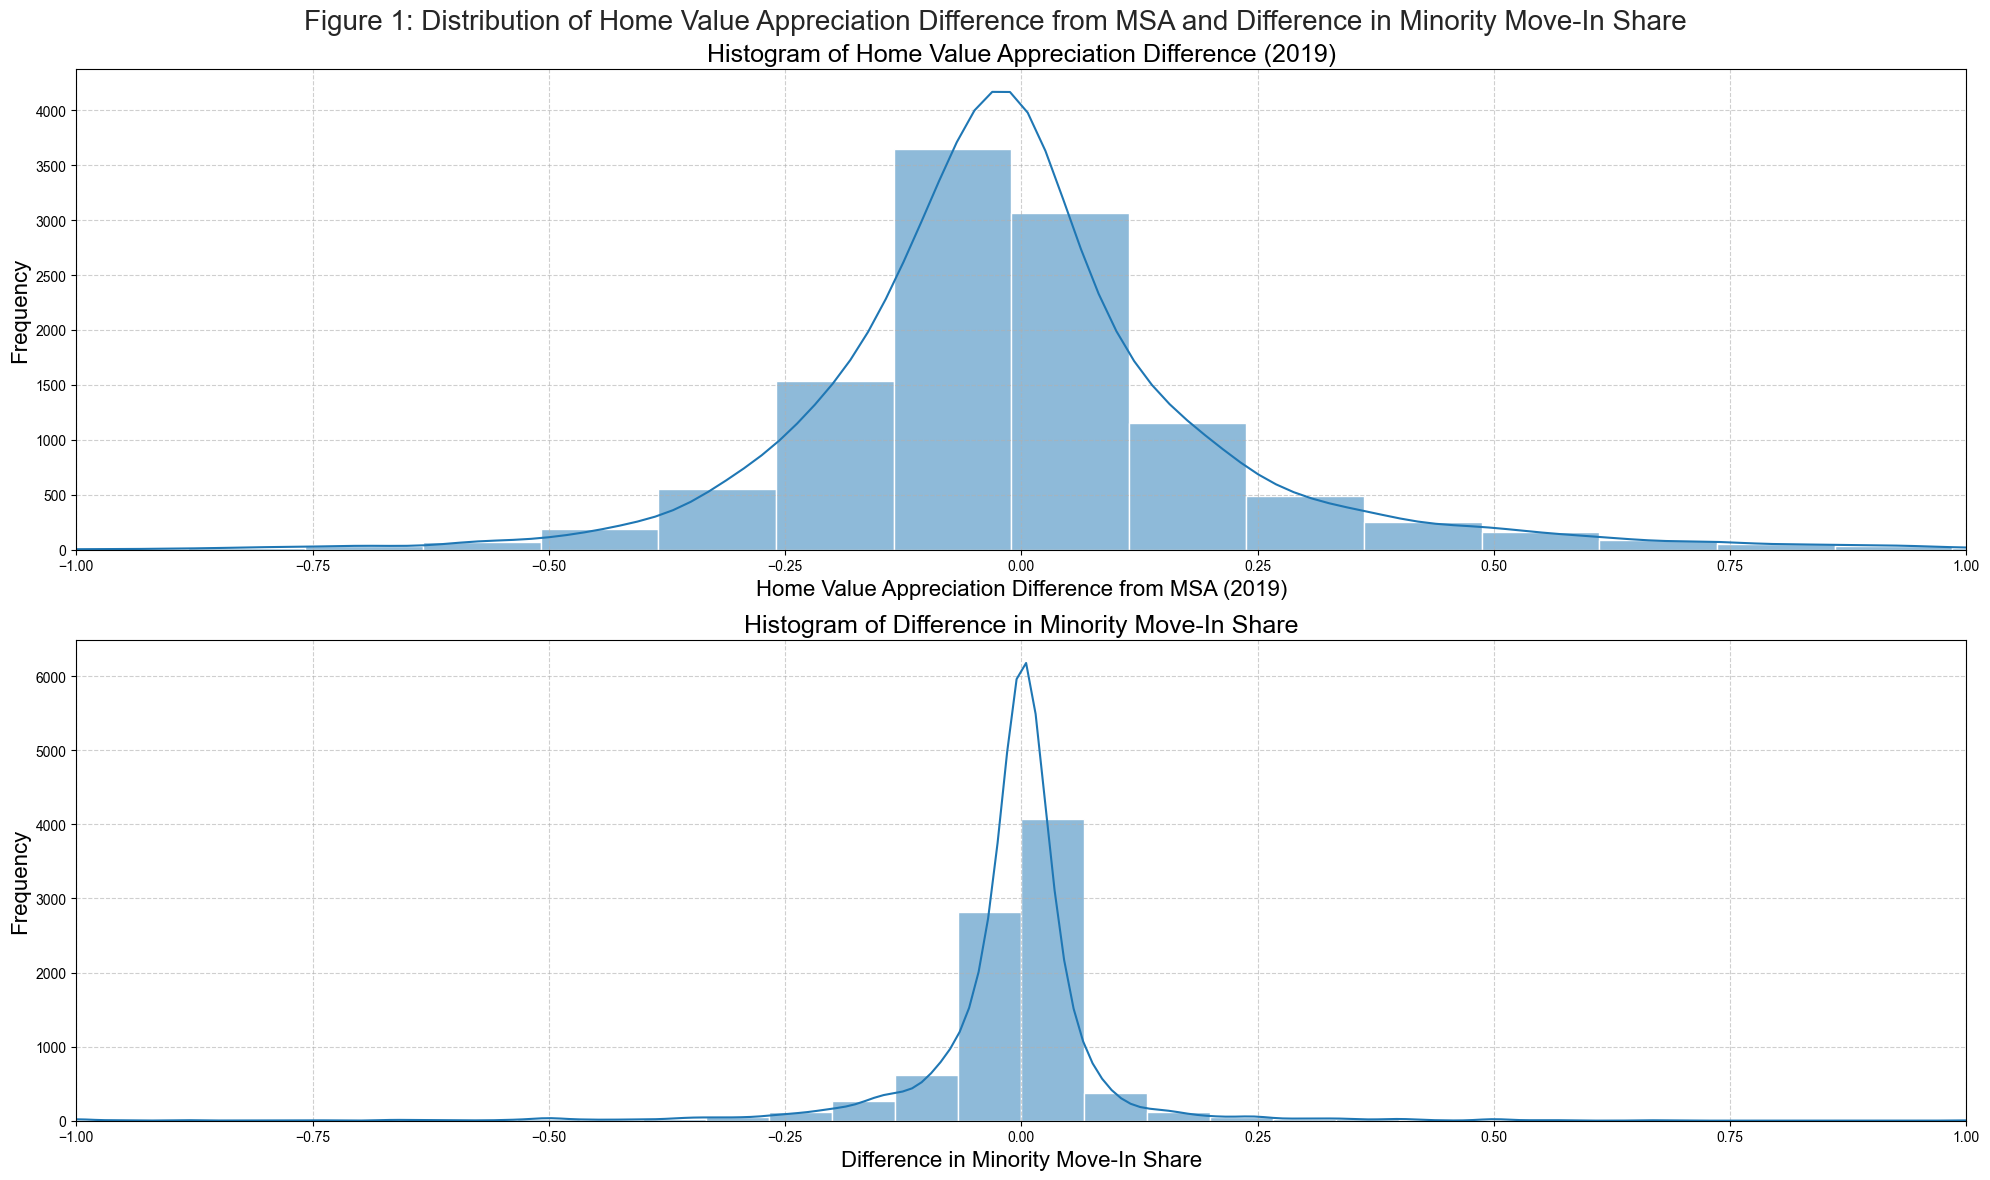

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12)) 
sns.set_style("whitegrid")

sns.histplot(data_table['value_diff_2019'], bins=30, kde=True, ax=axs[0])
axs[0].set_xlabel('Home Value Appreciation Difference from MSA (2019)', fontsize=16)
axs[0].set_ylabel('Frequency', fontsize=16)
axs[0].set_title('Histogram of Home Value Appreciation Difference (2019)', fontsize=18)
axs[0].set_xlim(-1, 1) 
axs[0].grid(True, linestyle="--", alpha=0.6)

sns.histplot(data_table['early_late_ratio'], bins=30, kde=True, ax=axs[1])
axs[1].set_xlabel('Difference in Minority Move-In Share', fontsize=16)
axs[1].set_ylabel('Frequency', fontsize=16)
axs[1].set_xlim(-1, 1)  
axs[1].set_title('Histogram of Difference in Minority Move-In Share', fontsize=18)
axs[1].grid(True, linestyle="--", alpha=0.6)

fig.suptitle('Figure 1: Distribution of Home Value Appreciation Difference from MSA and Difference in Minority Move-In Share', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.93) 
plt.show()

The long x-axis on both of these plots is not a mistake. As shown in the summary tables above, the data has an incredibly large range. This plot shows how incredibly wide the range is in home value appreciation and minority move-in share (and how incredibly concentrated the difference in minority move-in share is around zero). This figure shows how large the distribution is. In the next few plots we will attempt to answer my research question and see to what extent the distribution on the left can be explained by the distribution on the right.

### Time Series of $Y$ With Discrete $X$

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\thest\AppData\Local\Temp\ipykernel_31236\1897853385.py:8: SyntaxWarning: invalid escape sequence '\d'
  melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)


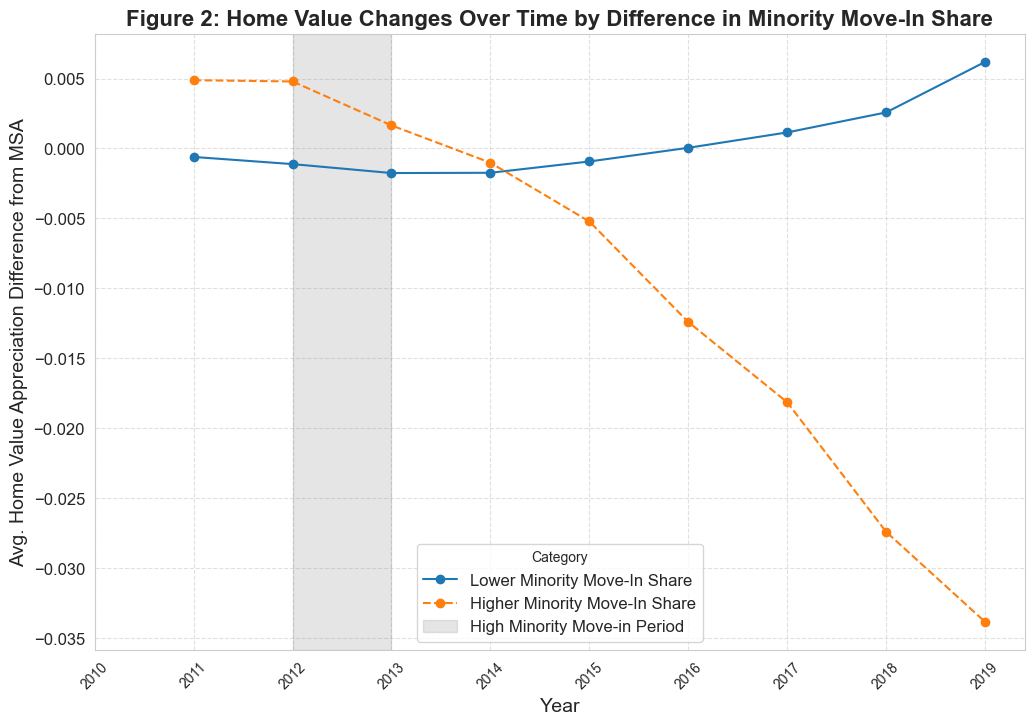

In [ ]:
plt.figure(figsize=(12, 8))
# Categorize early_late_ratio into high and low
data_table['early_late_category'] = pd.cut(data_table['early_late_ratio'], bins=[-float('inf'), 0.00, float('inf')], labels=['lower', 'higher'])

# Melt the dataframe for easier plotting
melted_data = data_table.melt(id_vars=['early_late_category'], value_vars=[col for col in data_table.columns if col.startswith('value_diff_')], var_name='year', value_name='value_diff')
# Extract numeric year
melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)
# Compute average value difference per category and year
avg_value_change = melted_data.groupby(['early_late_category', 'year'], observed=False)['value_diff'].mean().reset_index()

# Define colors
colors = {"lower": "#1f77b4", "higher": "#ff7f0e"}  # Blue for low, Orange for high
linestyles = {"lower": "solid", "higher": "dashed"}  # Solid & dashed lines

# Plot each category with distinct styling
for category, data in avg_value_change.groupby('early_late_category', observed=False):
    plt.plot(data['year'], data['value_diff'], label=f'{category.capitalize()} Minority Move-In Share', color=colors[category], linestyle=linestyles[category], marker='o')

# Add shaded area for high minority move-in period
plt.axvspan(2012, 2013, color='gray', alpha=0.2, label='High Minority Move-in Period')

# Labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg. Home Value Appreciation Difference from MSA', fontsize=14)
plt.title('Figure 2: Home Value Changes Over Time by Difference in Minority Move-In Share', fontsize=16, fontweight='bold')

# Improved legend
plt.legend(title='Category', fontsize=12)
plt.xticks(range(avg_value_change['year'].min()-1, avg_value_change['year'].max() + 1), rotation=45)
plt.yticks(fontsize=12)

# Grid styling
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

This figure shows the difference in outcome between the treatment group (higher minority move-in share) and control group (lower / same minority move-in share). It seems to indicate that the treatment group already has lower values before the treatment period. During the treatment period, the values fall even more. After the treatment period, values stay similarly low, and then start to increase again after 2016. In contrast, the control group has increasing values for roughly the entire period. This seems to indicate that neighborhoods with a higher minority move-in share have depressed home value appreciation relative to groups without.

### Scatterplot of Main $X$ and $Y$

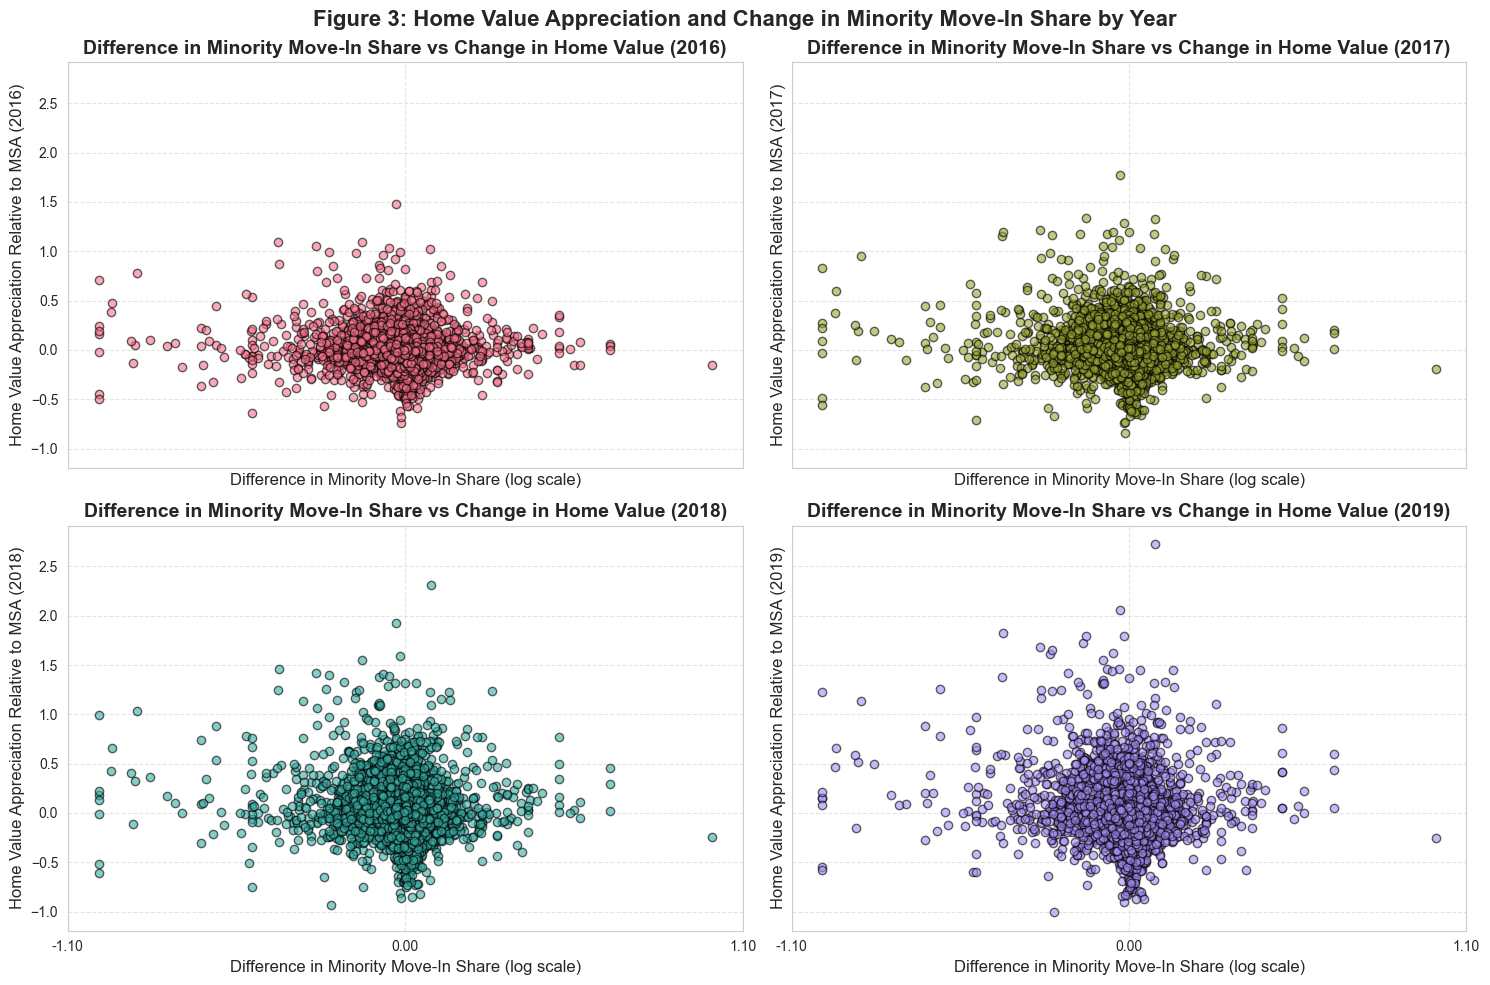

In [ ]:
# Filter data
filtered_data = data_table[data_table['total_pop'].abs() > 100]

# Define color palette
colors = sns.color_palette("husl", 4)  # Distinct colors for better visibility

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

years = [2016, 2017, 2018, 2019]
for i, year in enumerate(years):
    ax = axs[i // 2, i % 2]
    
    # Scatter plot with improved aesthetics
    ax.scatter(
        filtered_data['early_late_ratio'], 
        filtered_data[f'value_diff_{year}'], 
        alpha=0.6, color=colors[i], edgecolor='black'
    )
    ax.set_xscale('symlog')
    
    # Titles and labels
    ax.set_title(f'Difference in Minority Move-In Share vs Change in Home Value ({year})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Difference in Minority Move-In Share (log scale)', fontsize=12)
    ax.set_ylabel(f'Home Value Appreciation Relative to MSA ({year})', fontsize=12)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    # Grid styling
    ax.grid(True, linestyle="--", alpha=0.5)
# Improve layout
fig.suptitle('Figure 3: Home Value Appreciation and Change in Minority Move-In Share by Year', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

This figure shows something very important not shown in Figure 2, which is how wide the variation is. I chose a log scale to show more detail (as you can see, there are a few far outliers, with most of the data clustered near zero). From these scatterplots, it is very hard to conclude that there is any association between an increase in minority move-in share and the home appreciation relative to the MSA. The variation noticably increasees with time.

### Box Plot With Discrete $X$

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\thest\AppData\Local\Temp\ipykernel_31236\451903953.py:6: SyntaxWarning: invalid escape sequence '\d'
  melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)


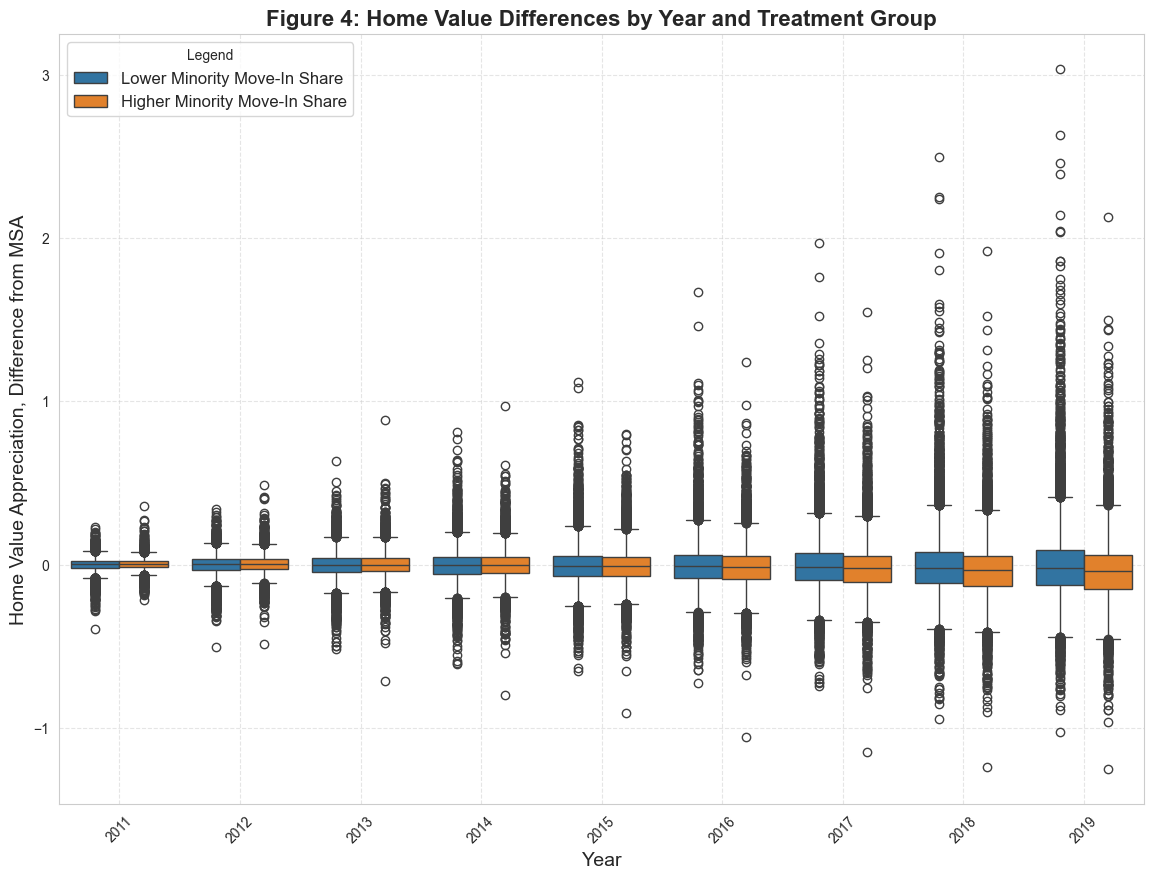

In [ ]:
data_table['early_late_category'] = pd.cut(data_table['early_late_ratio'], bins=[-float('inf'), 0.00, float('inf')], labels=['Lower Minority Move-In Share', 'Higher Minority Move-In Share'])

# Melt the dataframe for easier plotting
melted_data = data_table.melt(id_vars=['early_late_category'], value_vars=[col for col in data_table.columns if col.startswith('value_diff_')], var_name='year', value_name='value_diff')
# Extract numeric year
melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)
# Compute average value difference per category and year
avg_value_change = melted_data.groupby(['early_late_category', 'year'], observed=False)['value_diff'].mean().reset_index()
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(14, 10))
sns.boxplot(x='year', y='value_diff', hue='early_late_category', data=melted_data, palette={"Lower Minority Move-In Share": "#1f77b4", "Higher Minority Move-In Share": "#ff7f0e"})

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Home Value Appreciation, Difference from MSA', fontsize=14)
plt.title('Figure 4: Home Value Differences by Year and Treatment Group', fontsize=16, fontweight='bold')
plt.legend(title='Legend', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

This figure shows the extent of the increase in variation across the time period, and that there is a slight decrease in the median for the higher minority move-in share group. Again, there is an increidbly high degree of variation in home values relative to the metropolitan area, much of which cannot be explained by the change in minority move-in share. This answers my research question with "yes, a high minority share does reduce the average, but the variation is high enough that we can't conclude anything".

# Part Two

## The Message

My message is that **I am unable to draw conclusions from the data about the effect of minority move-ins on home-value appreciation**. It is summed up best with the following scatterplot, which demonstrates the lack of clear relationship

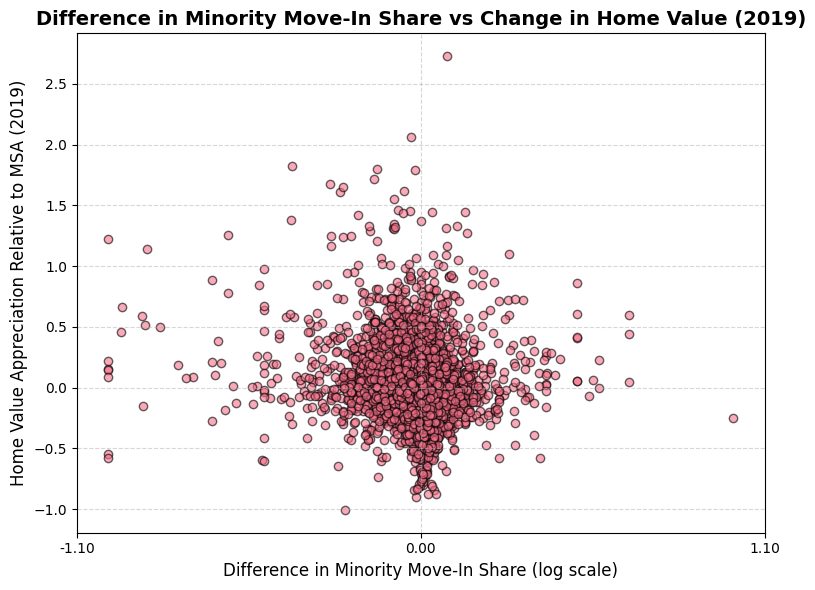

In [ ]:
# Filter data
filtered_data = data_table[data_table['total_pop'].abs() > 100]

# Define color palette
colors = sns.color_palette("husl", 4)  # Distinct colors for better visibility

# Create subplot for 2019 only
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with improved aesthetics for 2019
ax.scatter(
    filtered_data['early_late_ratio'], 
    filtered_data['value_diff_2019'], 
    alpha=0.6, color=colors[0], edgecolor='black'
)
ax.set_xscale('symlog')

# Titles and labels
ax.set_title('Difference in Minority Move-In Share vs Change in Home Value (2019)', fontsize=14, fontweight='bold')
ax.set_xlabel('Difference in Minority Move-In Share (log scale)', fontsize=12)
ax.set_ylabel('Home Value Appreciation Relative to MSA (2019)', fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Grid styling
ax.grid(True, linestyle="--", alpha=0.5)

# Improve layout
plt.tight_layout()
plt.show()

## Maps

In [ ]:
import geopandas as gpd

In [ ]:
zips = gpd.read_file('shapefiles/zips/US_zcta_2010.shp')
data_table['zip'] = data_table['zip'].astype(int)
zips['GEOID10'] = zips['GEOID10'].astype(int)
zips = zips.merge(data_table, left_on='GEOID10', right_on='zip')


C:\Users\emers\AppData\Local\Temp\ipykernel_6544\1516833139.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.3)


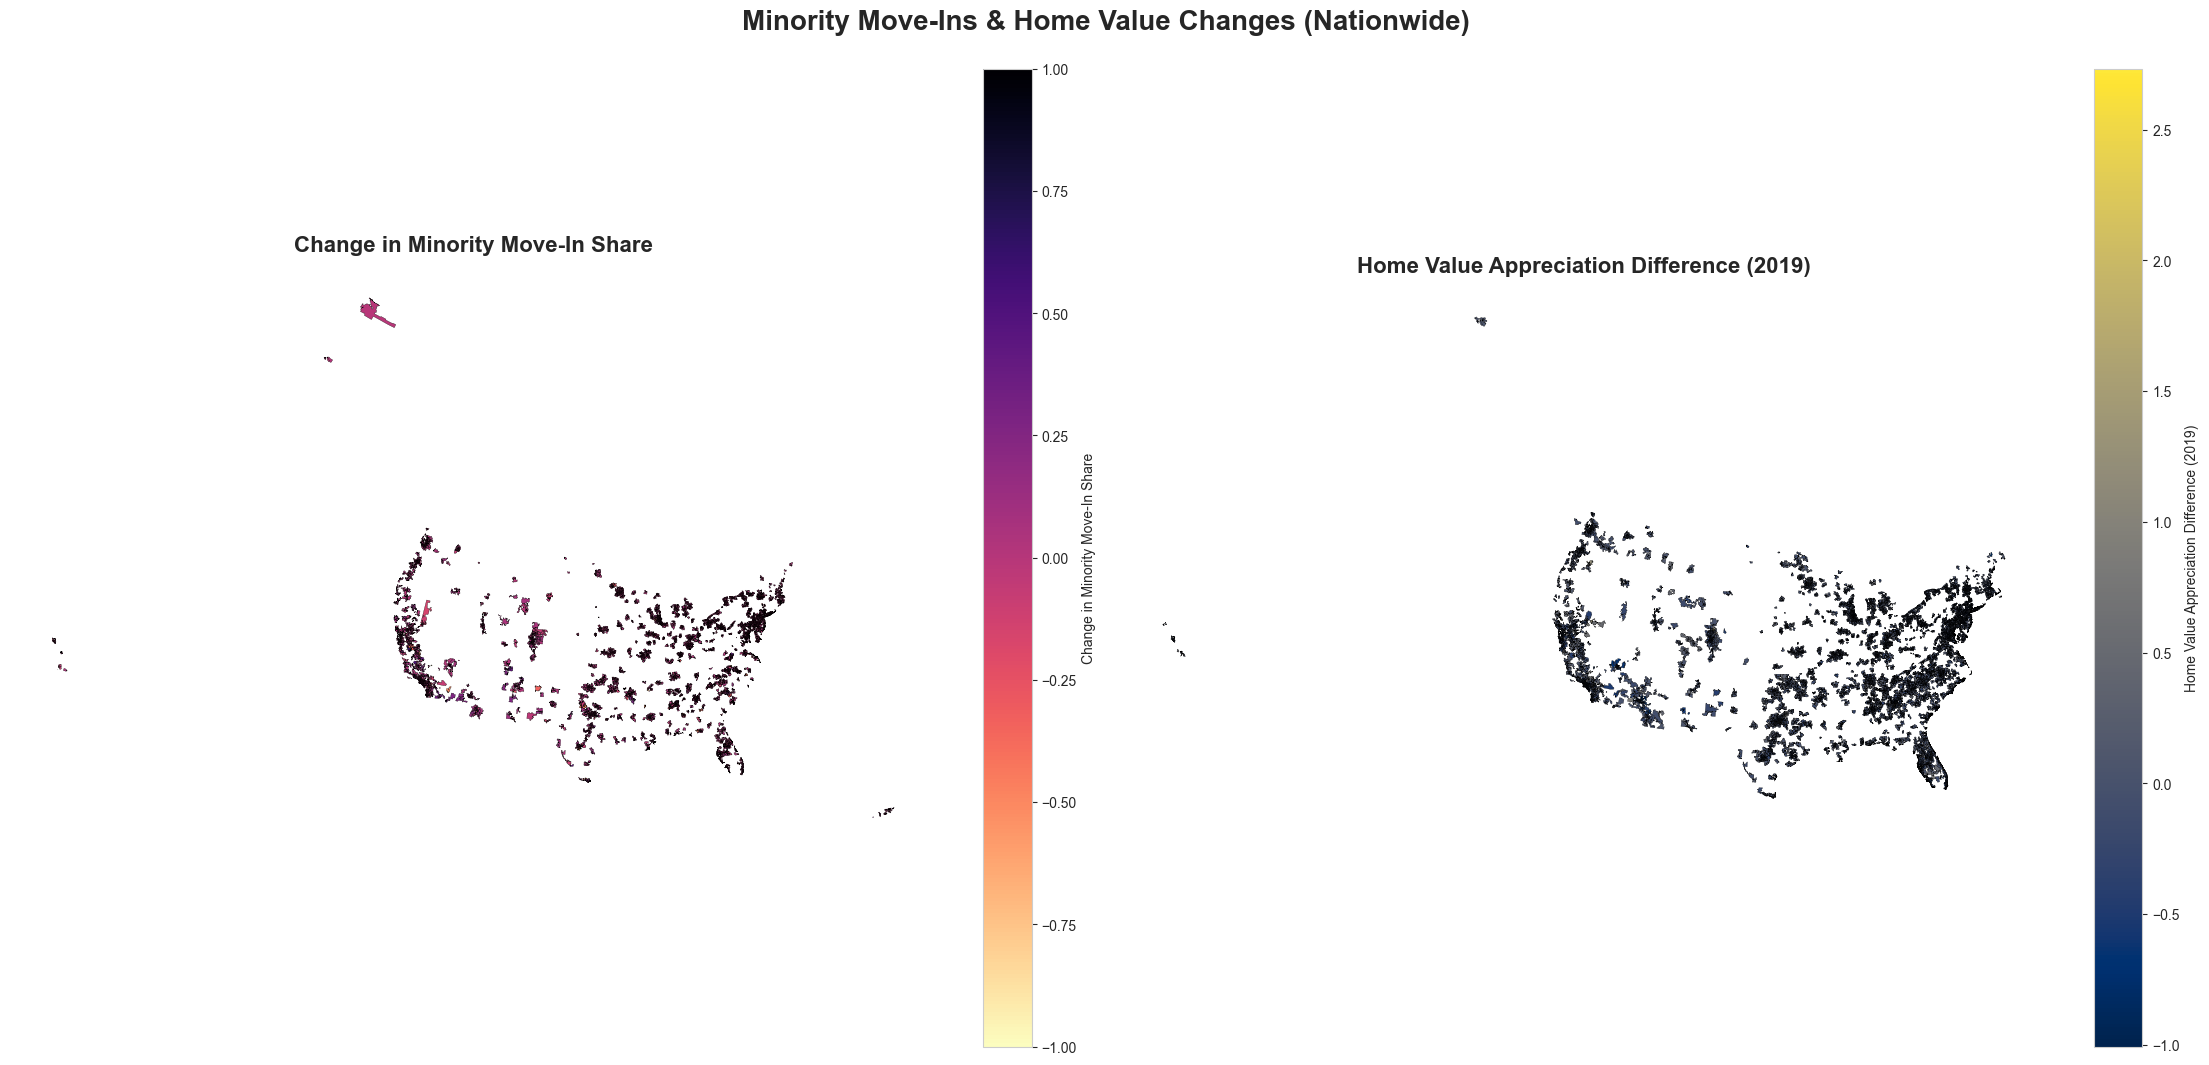

In [ ]:
fig, (gax1, gax2) = plt.subplots(1, 2, figsize=(22, 10), constrained_layout=True)

cmap1 = "magma_r"
plot1 = zips.plot(
    ax=gax1, edgecolor='black', linewidth=0.2, cmap=cmap1, legend=True, 
    column='early_late_ratio',
    legend_kwds={'label': 'Change in Minority Move-In Share'}
)
gax1.set_title('Change in Minority Move-In Share', fontsize=16, fontweight='bold', pad=15)
gax1.axis('off')
gax1.set_aspect('equal')  # Force equal aspect ratio

cmap2 = "cividis"
plot2 = zips.plot(
    ax=gax2, edgecolor='black', linewidth=0.2, cmap=cmap2, legend=True, 
    column='value_diff_2019',
    legend_kwds={'label': 'Home Value Appreciation Difference (2019)'}
)
gax2.set_title('Home Value Appreciation Difference (2019)', fontsize=16, fontweight='bold', pad=15)
gax2.axis('off')
gax2.set_aspect('equal')  # Force equal aspect ratio

fig.suptitle("Minority Move-Ins & Home Value Changes (Nationwide)", 
             fontsize=20, fontweight='bold', y=1.05)

# Adjust plot spacing
fig.subplots_adjust(wspace=0.3)

plt.show()

As you can see, this map alone is not very useful, as we are mostly looking at fine effects on a neighborhood level, meaning nationwide data is too broad. In the map below, we zoom in to only look at the Boston MSA.

C:\Users\emers\AppData\Local\Temp\ipykernel_6544\1602334164.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.3)


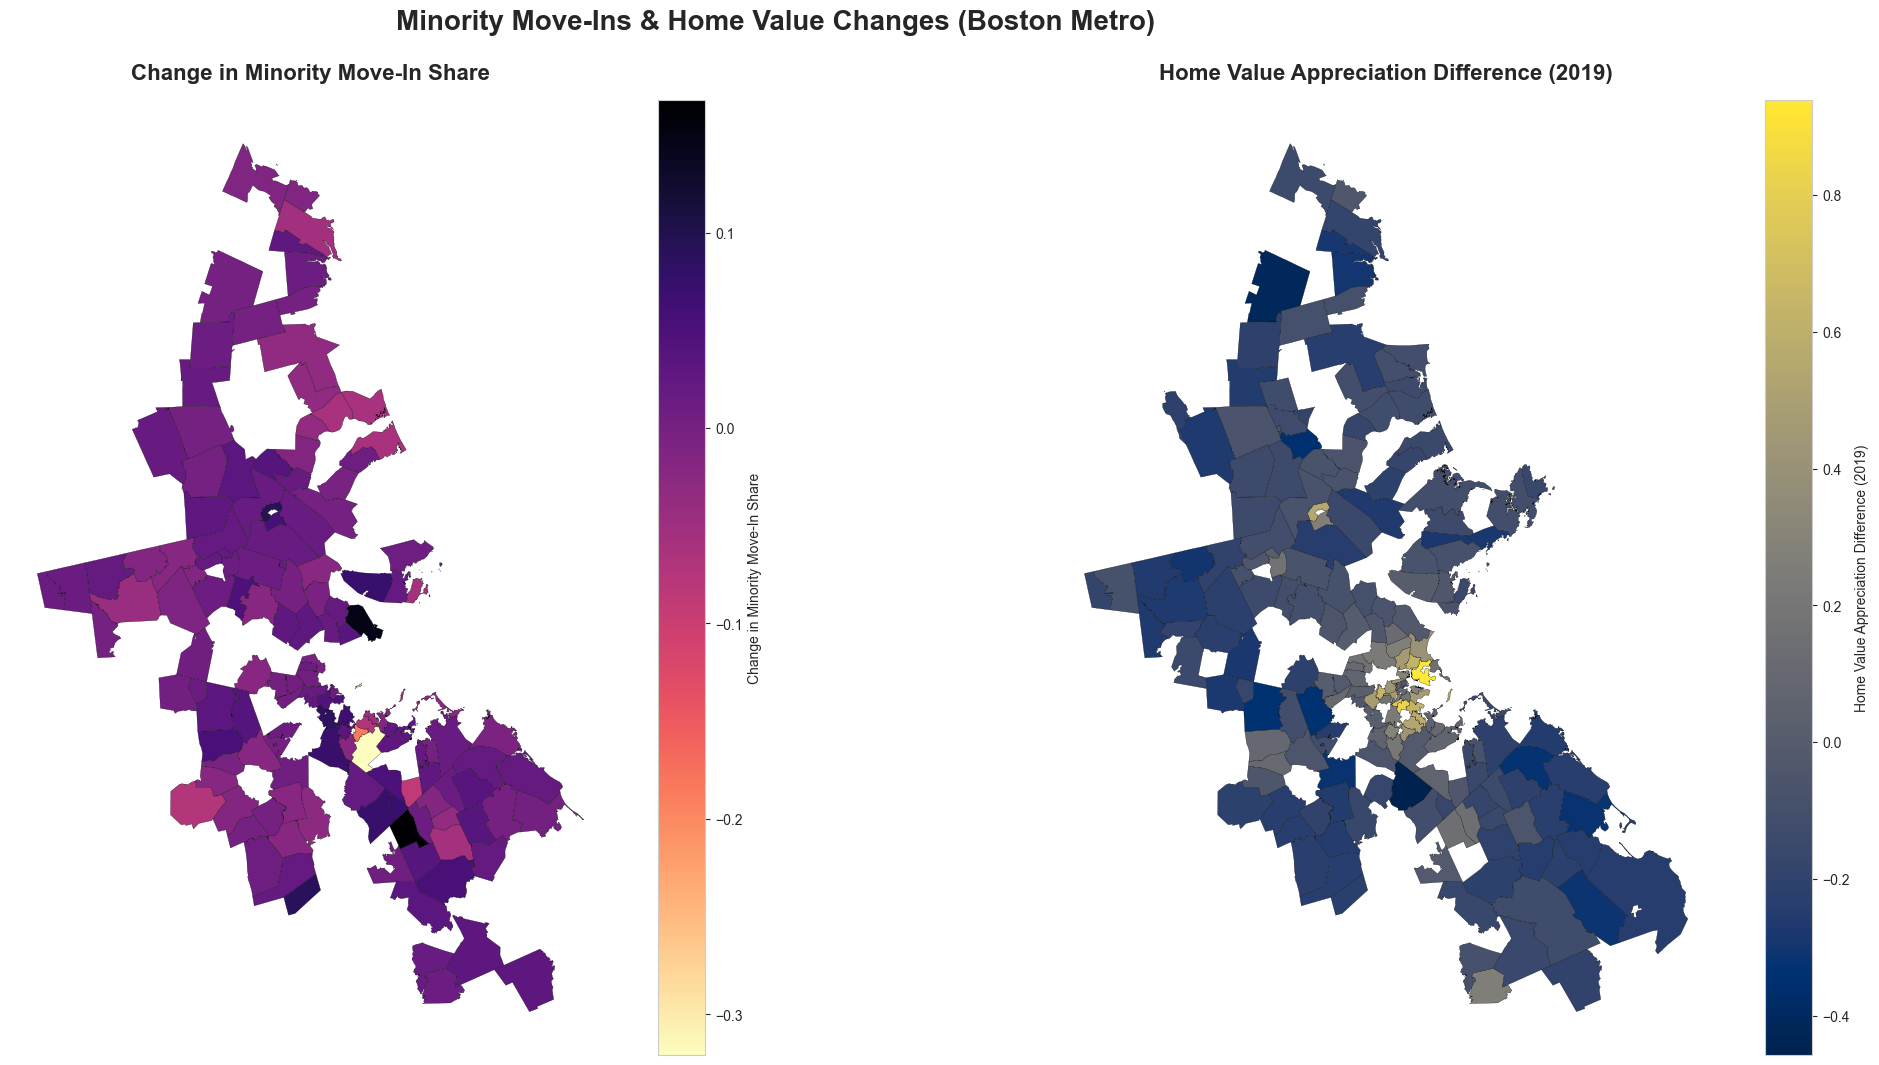

In [ ]:
fig, (gax1, gax2) = plt.subplots(1, 2, figsize=(22, 10), constrained_layout=True)

cmap1 = "magma_r"
plot1 = zips.query("msa_code == 14460.0").plot(
    ax=gax1, edgecolor='black', linewidth=0.2, cmap=cmap1, legend=True, 
    column='early_late_ratio',
    legend_kwds={'label': 'Change in Minority Move-In Share'}
)
gax1.set_title('Change in Minority Move-In Share', fontsize=16, fontweight='bold', pad=15)
gax1.axis('off')
gax1.set_aspect('equal')  # Force equal aspect ratio

cmap2 = "cividis"
plot2 = zips.query("msa_code == 14460.0").plot(
    ax=gax2, edgecolor='black', linewidth=0.2, cmap=cmap2, legend=True, 
    column='value_diff_2019',
    legend_kwds={'label': 'Home Value Appreciation Difference (2019)'}
)
gax2.set_title('Home Value Appreciation Difference (2019)', fontsize=16, fontweight='bold', pad=15)
gax2.axis('off')
gax2.set_aspect('equal')  # Force equal aspect ratio

fig.suptitle("Minority Move-Ins & Home Value Changes (Boston Metro)", 
             fontsize=20, fontweight='bold', y=1.05)

# Adjust plot spacing
fig.subplots_adjust(wspace=0.3)

plt.show()

These maps demonstrate no clear spatial relationship between the change in minority move-in share and home value appreciation. They also show the gaps in minority-move in data in downtowns (very few single family homes to purchase), and the gaps in home value and minority move-in data throughout the rest of the sample. Overall, these maps don't support any conclusion, positive or negative, to my research question.

C:\Users\emers\AppData\Local\Temp\ipykernel_6544\2234367526.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.3)


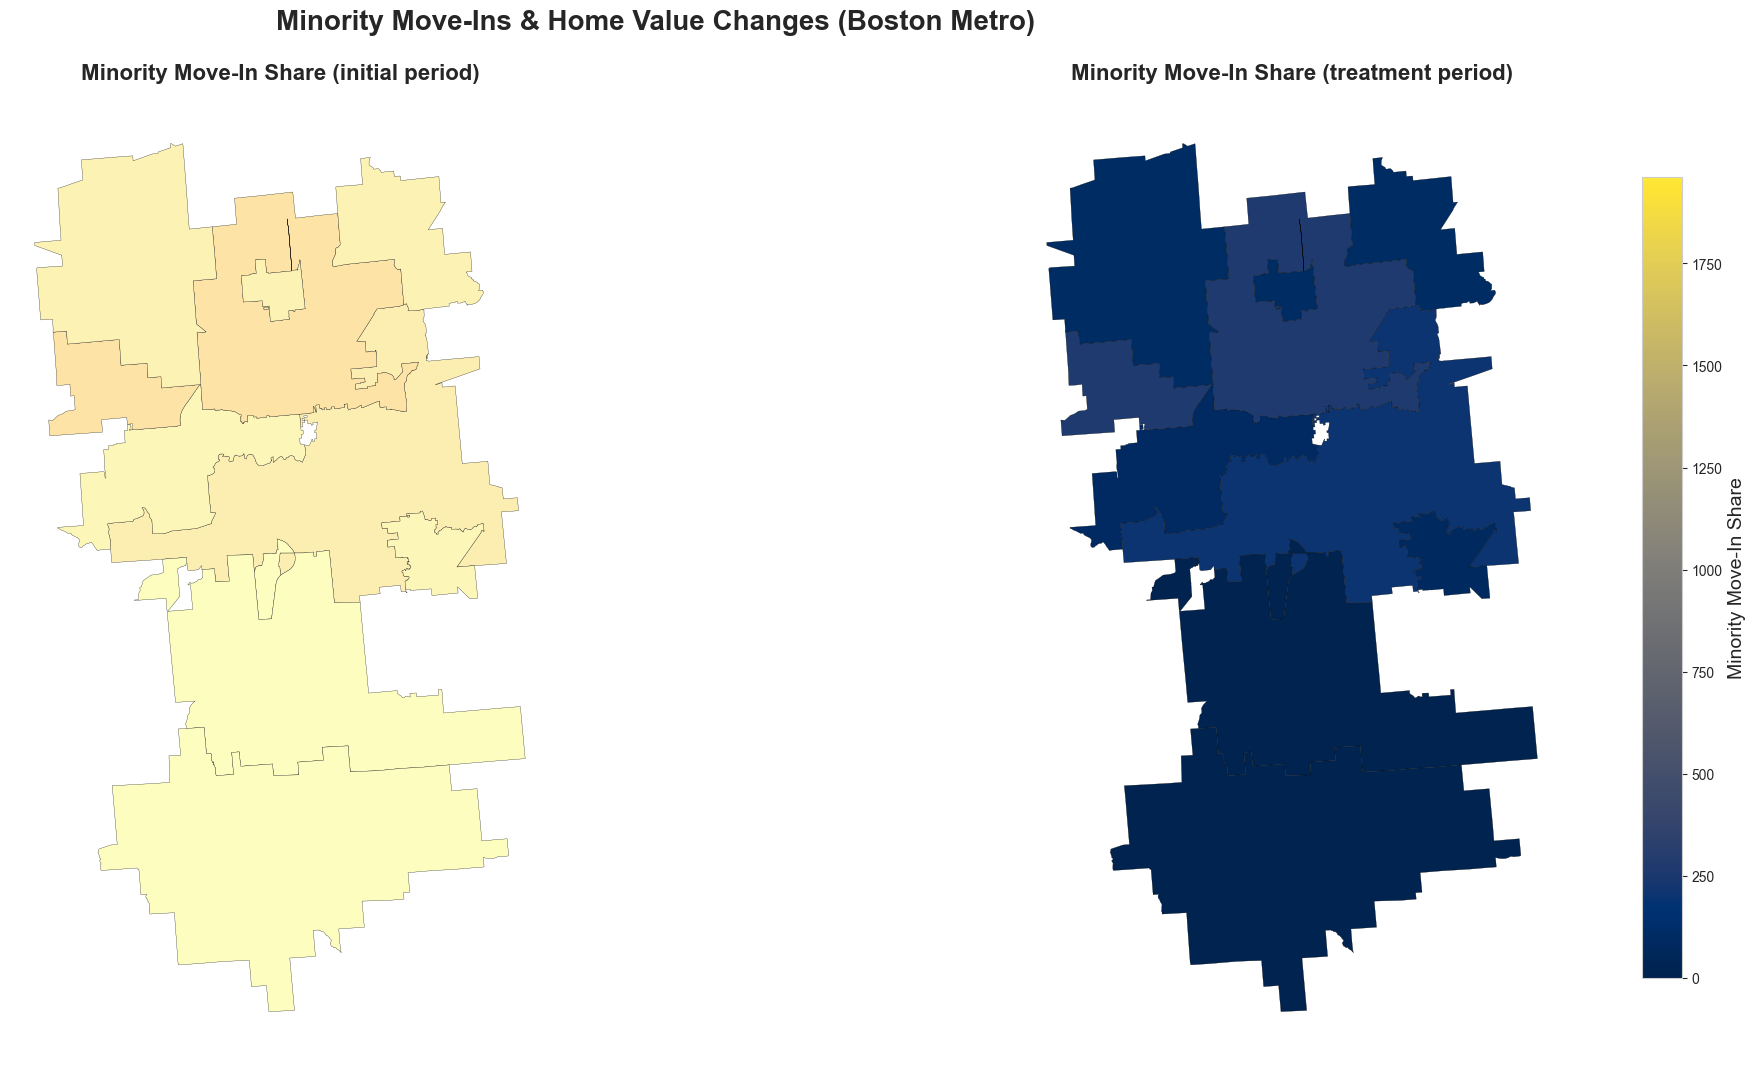

In [ ]:
# Define the common color range for both maps
vmin = min(zips['early_move_ins'].min(), zips['late_move_ins'].min())
vmax = max(zips['early_move_ins'].max(), zips['late_move_ins'].max())

fig, (gax1, gax2) = plt.subplots(1, 2, figsize=(22, 10), constrained_layout=True)

# First plot
cmap1 = "magma_r"
plot1 = zips.query("msa_code == 19500.0").plot(
    ax=gax1, edgecolor='black', linewidth=0.2, cmap=cmap1, 
    column='early_move_ins', legend=False,  # Set legend=False here
    vmin=vmin, vmax=vmax  # Set the color scale to match the common range
)
gax1.set_title('Minority Move-In Share (initial period)', fontsize=16, fontweight='bold', pad=15)
gax1.axis('off')
gax1.set_aspect('equal')  # Force equal aspect ratio

# Second plot
cmap2 = "cividis"
plot2 = zips.query("msa_code == 19500.0").plot(
    ax=gax2, edgecolor='black', linewidth=0.2, cmap=cmap2, 
    column='late_move_ins', legend=False,  # Set legend=False here
    vmin=vmin, vmax=vmax  # Set the color scale to match the common range
)
gax2.set_title('Minority Move-In Share (treatment period)', fontsize=16, fontweight='bold', pad=15)
gax2.axis('off')
gax2.set_aspect('equal')  # Force equal aspect ratio

# Add a single shared colorbar
sm = plt.cm.ScalarMappable(cmap='cividis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Only needed for the colorbar to show properly
cbar = fig.colorbar(sm, ax=[gax1, gax2], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Minority Move-In Share', fontsize=14)

# Add the overall title
fig.suptitle("Minority Move-Ins & Home Value Changes (Boston Metro)", fontsize=20, fontweight='bold', y=1.05)

# Adjust plot spacing
fig.subplots_adjust(wspace=0.3)

plt.show()

huh my data is FUCKED

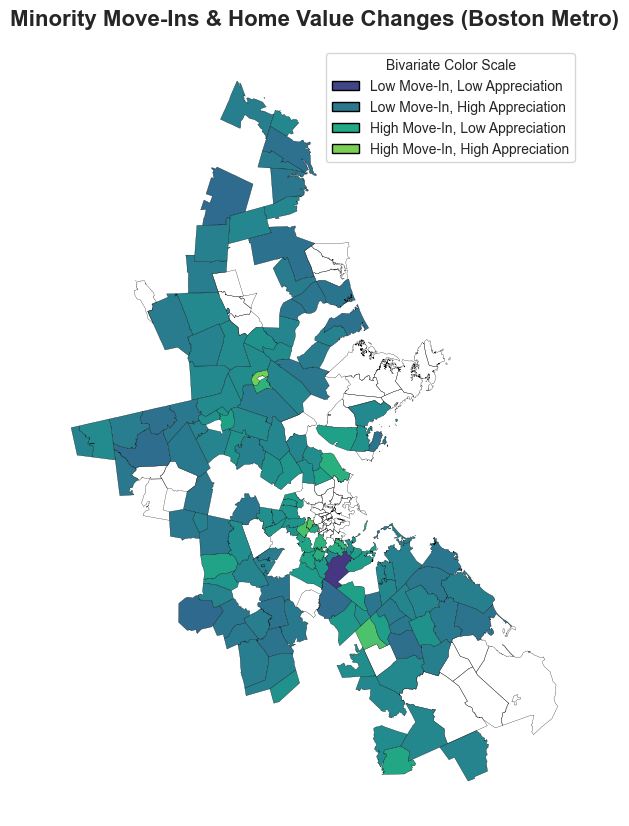

In [ ]:
# Normalize function
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

msa_code = 14460.0
df = zips.query("msa_code == @msa_code").copy()

# Normalize variables
df['norm_movein'] = normalize(df['early_late_ratio'])
df['norm_value'] = normalize(df['value_diff_2019'])

# Create colormap
cmap = plt.get_cmap("viridis")  
colors = cmap(df['norm_movein'] * 0.5 + df['norm_value'] * 0.5) 

fig, ax = plt.subplots(figsize=(12, 10))
df.plot(ax=ax, color=colors, edgecolor='black', linewidth=0.2)

# Title and layout
ax.set_title("Minority Move-Ins & Home Value Changes (Boston Metro)", 
             fontsize=16, fontweight='bold', pad=15)
ax.axis('off')

# Legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=cmap(0.2), edgecolor='black', label="Low Move-In, Low Appreciation"),
    Patch(facecolor=cmap(0.4), edgecolor='black', label="Low Move-In, High Appreciation"),
    Patch(facecolor=cmap(0.6), edgecolor='black', label="High Move-In, Low Appreciation"),
    Patch(facecolor=cmap(0.8), edgecolor='black', label="High Move-In, High Appreciation"),
]
ax.legend(handles=legend_elements, title="Bivariate Color Scale", loc="upper right")

plt.show()

This bivariate chloropleth reinforces the fact that there is little clear correlation between the change in minority move-in share and home-value appreciation. While many zip codes (ZCTAs) are colored a shade of teal (consistent with an inverse relationship), there are many colored green or dark blue, which would be consistent with a direct relationship. 

## Regressions

In [25]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

### Baseline models

In [26]:
reg_data = data_table.dropna(subset=['early_late_ratio', 'value_diff_2019', 'msa_avg_value_ratio_2019'])
reg_data['white_x_early_late_ratio'] = reg_data['white'] * reg_data['early_late_ratio']
reg_data['intercept'] = 1
X0 = reg_data[['intercept', 'early_late_ratio']] # Barebones regression
X1 = reg_data[['intercept', 'early_late_ratio', 'msa_avg_value_ratio_2019']] # Baseline regression
X2 = reg_data[['intercept', 'early_late_ratio', 'msa_avg_value_ratio_2019', 'total_pop', 'white']] # Previous racial demos
X3 = reg_data[['intercept', 'early_late_ratio', 'msa_avg_value_ratio_2019', 'white']]
X3 = reg_data[['intercept', 'early_late_ratio', 'msa_avg_value_ratio_2019', 'white_x_early_late_ratio']]
y = reg_data['value_ratio_2017']
model0 = sm.OLS(y, X0).fit()
model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()

C:\Users\emers\AppData\Local\Temp\ipykernel_29368\2189008107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['white_x_early_late_ratio'] = reg_data['white'] * reg_data['early_late_ratio']
C:\Users\emers\AppData\Local\Temp\ipykernel_29368\2189008107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['intercept'] = 1


In [27]:
stargazer = Stargazer([model0, model1, model2, model3])
stargazer.custom_columns(["Change in Average Home Value (%) (2010-2017)"],[4])
HTML(stargazer.render_html())
# print(stargazer.render_latex()) #if you use Latex (Overleaf.com)

Model (0) shows a barebones regression with no controls -- it indicates that there is a slight positive relationship between the change in minority move-ins and home value appreciation, but it's practically useless as it has very low explanatory power. Model (1) shows a baseline model controlling only for MSA appreciation -- it indicates an even more slight positive relationship, but has much higher explanatory power. Model (2) indicates a similarly low positive relationship, and shows that there is little-to-no confounding occuring due to population size or whiteness of the area.  Model (3) analyzes the interaction between zip-code whiteness and the change from the increase in minority move-in share and finds that there is no clear interaction.

### Neighborhood income characteristics

In [28]:
reg_data = data_table.dropna(subset=['early_late_ratio', 'value_diff_2019', 'msa_avg_value_ratio_2019', 'per_cap_inc', 'gini_index'])
reg_data['gini_x_early_late'] = reg_data['gini_index'] * reg_data['early_late_ratio']
reg_data['intercept'] = 1
X4 = reg_data[['intercept', 'early_late_ratio', 'per_cap_inc', 'msa_avg_value_ratio_2019']]
X5 = reg_data[['intercept', 'early_late_ratio', 'gini_index', 'msa_avg_value_ratio_2019']]
X6 = reg_data[['intercept', 'early_late_ratio', 'gini_index', 'msa_avg_value_ratio_2019', 'gini_x_early_late']]
y = reg_data['value_ratio_2017']
model4 = sm.OLS(y, X4).fit()
model5 = sm.OLS(y, X5).fit()
model6 = sm.OLS(y, X6).fit()

C:\Users\emers\AppData\Local\Temp\ipykernel_29368\2476887300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['gini_x_early_late'] = reg_data['gini_index'] * reg_data['early_late_ratio']
C:\Users\emers\AppData\Local\Temp\ipykernel_29368\2476887300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['intercept'] = 1


In [1]:
stargazer = Stargazer([model4, model5, model6])
stargazer.custom_columns(["Home Value Change (%) (2010-2017)"],[3])
HTML(stargazer.render_html())
# print(stargazer.render_latex()) #if you use Latex (Overleaf.com)

NameError: name 'Stargazer' is not defined

This shi useless fr

### Political affiliation

In [30]:
reg_data = data_table.dropna(subset=['early_late_ratio', 'value_diff_2019', 'msa_avg_value_ratio_2019', 'pct_rep'])
reg_data['rep_x_early_late'] = reg_data['pct_rep'] * reg_data['early_late_ratio']
reg_data['intercept'] = 1
X7 = reg_data[['intercept', 'early_late_ratio', 'pct_rep', 'msa_avg_value_ratio_2019']]
X8 = reg_data[['intercept', 'early_late_ratio', 'rep_x_early_late', 'msa_avg_value_ratio_2019', 'pct_rep']]
y = reg_data['value_ratio_2017']
model7 = sm.OLS(y, X7).fit()
model8 = sm.OLS(y, X8).fit()

C:\Users\emers\AppData\Local\Temp\ipykernel_29368\523599092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['rep_x_early_late'] = reg_data['pct_rep'] * reg_data['early_late_ratio']
C:\Users\emers\AppData\Local\Temp\ipykernel_29368\523599092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['intercept'] = 1


In [31]:
stargazer = Stargazer([model7, model8])
stargazer.custom_columns(["Home Value Change (%) (2010-2017)"],[2])
HTML(stargazer.render_html())
# print(stargazer.render_latex()) #if you use Latex (Overleaf.com)

Low key rpublicans are fcking cringe

### Preferred specification

When evaluating regressions, I am looking for significant terms. An ideal regression would have clear conclusions with significant terms and a (reasonably) high $R^2$. 

Many regression specifications above introduce control variables that end up having low significance, and many (surprisingly, at times) appear to have no clear impact on the outcome variable. As a result, the regression that I find tells the best story is the baseline regression:
$$\text{Home value appreciation}=\beta_0+\beta_1(\text{Increase in minority move-in share})+\beta_2(\text{Home value appreciation of MSA})$$
This model indicates that there is a very small positive, significant effect from an increased minority move-in share on home-value appreciation. This is a surprising result, but given that it is small, it seems to indicate there is little-to-no effect of change in minority move-in share on home-value appreciation.

# Part Three

## Conclusion

In this paper, I analyze the link between an increase in the share of minority move-ins and home values on a neighborhood level. I construct a table of zip codes that includes, from federal loan underwriting data, the share of minority move-ins in the initial period, and the share of minority move-ins in the treatment period. The table also includes Zillow data showing the change in home values. I normalize this change in home values to the MSA the zip code is in, and the initial home values. 

My findings indicate that there is slight, if any association between my an increase in minority move-ins and home values, at least on a zip-code level. Regressions indicate that there is a slight, if any, increase in home-values due to an increase in minority move-ins. I am unable, with this level of data and analysis, to conclude the extent to which an increase in minority move-ins can explain any future change in home values (while controlling for MSA). There is little-to-no increased clarity when controlling for regional political affiliation, neighborhood income, or neighborhood income inequality.

## References

Appel, I., & Nickerson, J. (2016). Pockets of Poverty: The Long-Term Effects of Redlining. https://papers.ssrn.com/sol3/Delivery.cfm?abstractid=2852856

Korver-Glenn, E. (2018). Compounding inequalities: How Racial Stereotypes and Discrimination Accumulate Across the Stages of Housing Exchange. *American Sociological Review*, 83(4), 627–656. https://doi.org/10.1177/0003122418781774

Manson, S., Schroeder, J., Van Riper, D., Knowles, K., Kugler, T., Roberts, F., & Ruggles, S. (2024). *National Historical Geographic Information System: Version 19.0* [Dataset]. Minneapolis, MN: IPUMS. https://doi.org/10.18128/D050.V19.0

Quillian, L., Lee, J. J., & Honoré, B. (2020). Racial Discrimination in the U.S. Housing and Mortgage Lending Markets: A Quantitative Review of Trends, 1976–2016. *Race and Social Problems*, 12(1), 13–28. https://doi.org/10.1007/s12552-019-09276-x

Rothstein, R. (2017). *The Color of Law: A Forgotten History of How Our Government Segregated America* (First edition). Liveright Publishing Corporation, a division of W. W. Norton & Company.

Sood, A., Erhman-Solberg, K. (2024). The Long Shadow of Housing Discrimination: Evidence from Racial Covenants. https://drive.google.com/file/d/1uLSaQxWiSHKMuckF2gFpATywQD2J7No5/view?usp=embed_facebook

# Appendix

## Feedback Incorporation

- Improved data description in intro (no longer hyperlinked, full names written)
- Added further explanation for choices of variables
- Removed some redundant code explanation
- Added summary statistics for more variables
- Cleaned & imporved tables
- Improved readability and labeling of all plots
- Added more justification for graph scale
- Improved language use throughout project
- I didn't modify my analysis of Figure 4 because I don't think it's fair to say the graph supports my hypothesis. The point of that graph is to show how large the variation in home value appreciation is, especially compared to the small change from minority move-ins.